In [125]:
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from pyphot import unit
import pyphot
from pdastro import pdastroclass
from scipy.signal import savgol_filter
from scipy.stats import tstd

plt.style.use('default')

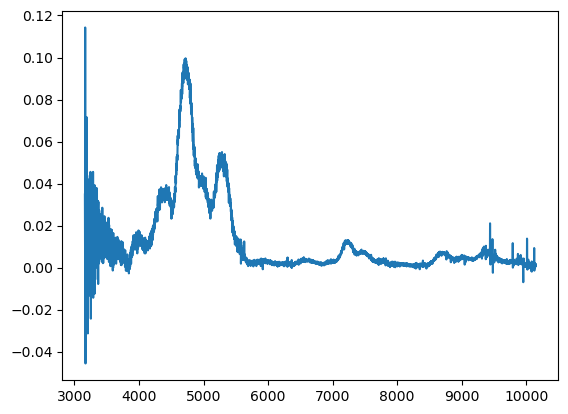

In [126]:
spec = pdastroclass()
spec.t = pd.read_csv('2023bee-combined-20240214_ap1.flm', skiprows=np.arange(0,8), names = ['wavelength', 'flux', 'dflux'], delimiter= ' ')
plt.plot(spec.t.wavelength, spec.t.flux)

(24.0, 12.0)

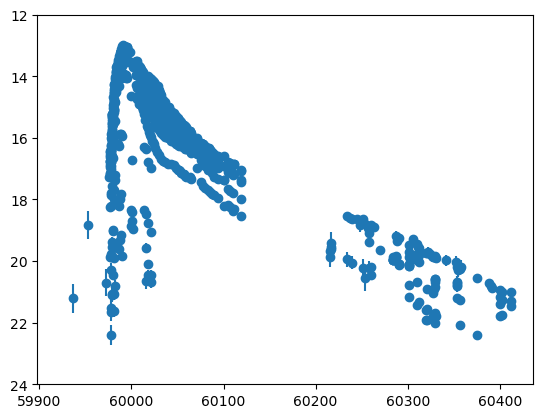

In [127]:
lc = pdastroclass()
lc.t = pd.read_csv('2023bee_data.snana.txt', header=44, delim_whitespace=True)

end_ix=lc.ix_equal('MJD', 'END:')
lc.t=lc.t.drop(end_ix)
lc.t.MJD = pd.to_numeric(lc.t.MJD)

lc.t = lc.t[lc.t.MAGERR <= .5]

plt.scatter(lc.t.MJD, lc.t.MAG)
plt.errorbar(lc.t.MJD, lc.t.MAG, lc.t.MAGERR, ls='none')
plt.ylim(24,12)

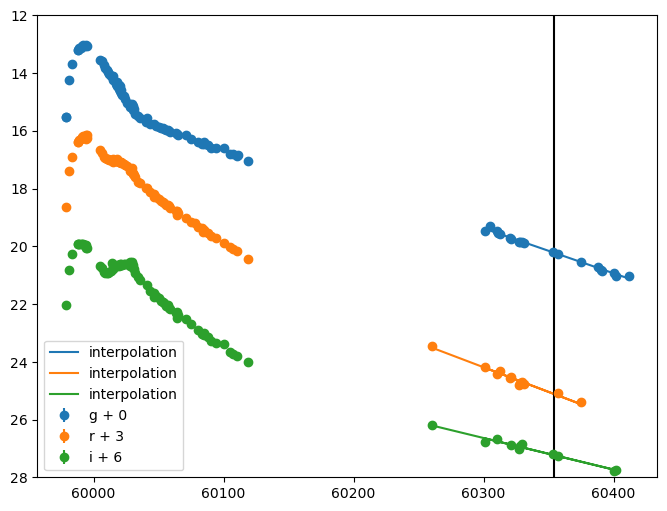

In [128]:
filters = lc.t.FLT.unique()
wanted_filts= [15,16,17]
usefilts = [filters[i] for i in wanted_filts]

plt.figure(figsize=(8,6))

colors=['tab:blue','tab:orange','tab:green']
maglist = []

for i, filt in enumerate(usefilts): #plot ATLAS and ZTF bands
    # Filter out the data in certain filet and has reasonable uncertainty 
    ind = (lc.t.FLT==filt)&(lc.t.MAGERR>0.)&(lc.t.MAGERR<1.) 
    plt.errorbar(lc.t.MJD[ind], lc.t.MAG[ind]+3*i, lc.t.MAGERR[ind], linestyle = 'None', marker = 'o', 
                 label = filt + ' + ' + str(3*i), color = colors[i])
    temp = lc.t[ind].reset_index()

    center = min(temp.MJD, key=lambda x:abs(x-60354))
    center_ix = temp.MJD[temp.MJD==center].index[0]

    ixs=(temp.MJD > 60120)

    a,b = np.polyfit(temp.MJD[ixs],temp.MAG[ixs],1)

    plt.plot(temp.MJD[ixs], a*temp.MJD[ixs]+(b+3*i), color=colors[i], label='interpolation')

    est_val = a*60354+b
    maglist.append(est_val)
plt.ylim(28, 12)
plt.legend()

plt.axvline(x=60354,color='black', label = 'MJD 60354')

In [129]:
wavelength = np.array(spec.t.wavelength) * unit['AA']
flux = np.array(spec.t.flux) * unit['erg/s/cm**2/AA']

lib = pyphot.get_library()

diffs = []

f = lib['PS1_g']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_g_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_g_mags - maglist[0])

f = lib['PS1_r']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_r_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_r_mags - maglist[1])

f = lib['PS1_i']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_i_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_i_mags - maglist[2])

avg_mag_diff = np.mean(diffs)
c = 10**(avg_mag_diff/2.5)
c_unc = (1/2.5)*(10**((1/2.5)*avg_mag_diff))*np.log(10)*np.std(diffs) 
print(c, "+/-", c_unc)

1.1450239190652479e-15 +/- 2.1435929953172553e-16


Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

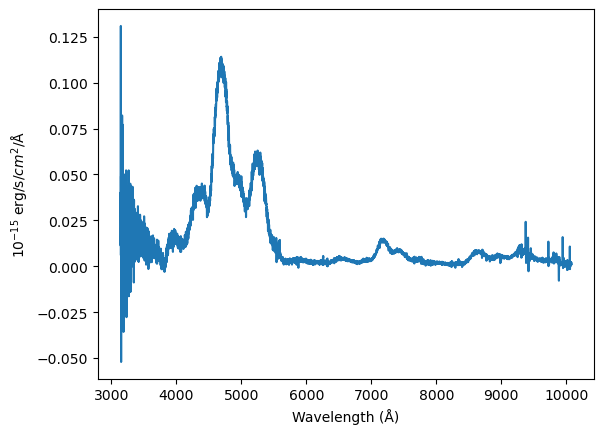

In [130]:
spec.t.flux = spec.t.flux*c
spec.t.wavelength = spec.t.wavelength/1.0067

plt.plot(spec.t.wavelength, spec.t.flux*(10**15))
plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

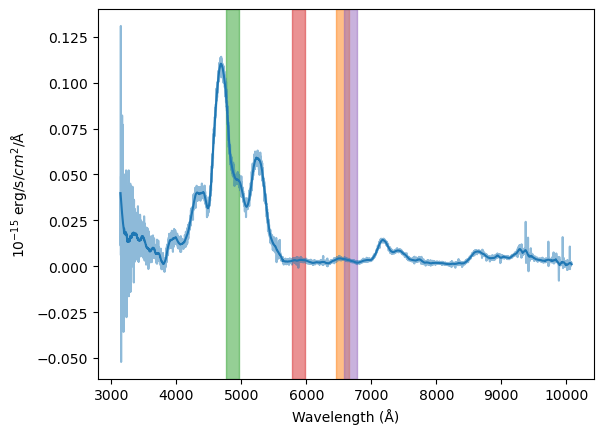

In [131]:
x = savgol_filter(spec.t.flux, 85, 3)

halpha = 6562.79
hbeta = 4861.35
hei5875 = 5875.61
hei6678 = 6678.15

plt.plot(spec.t.wavelength, spec.t.flux*(10**15), alpha=.5)
plt.plot(spec.t.wavelength, x*(10**15), color='tab:blue')

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

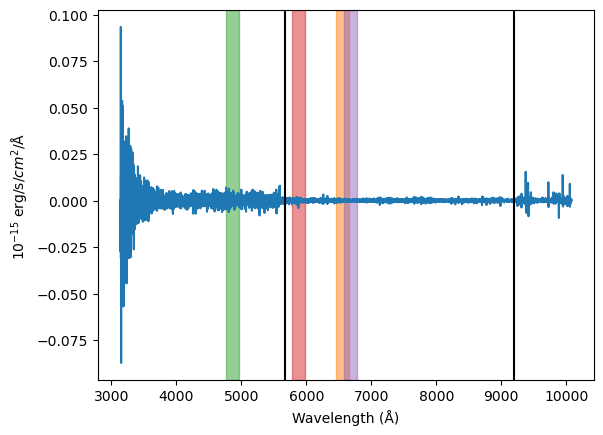

In [132]:
x = savgol_filter(spec.t.flux, 85, 3)

plt.plot(spec.t.wavelength, (spec.t.flux*(10**15))-(x*(10**15)))

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

begin = 5675
end = 9200
plt.axvline(begin, color='black')
plt.axvline(end, color='black')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

In [134]:
p = spec.ix_inrange('wavelength', begin, hei5875-100)
q = spec.ix_inrange('wavelength', hei5875+100, halpha-100)
r = spec.ix_inrange('wavelength', hei6678+100, end)
valid_ixs = list(np.concatenate([p, q, r]))

rms = spec.t.flux*(10**15)-(x*(10**15))

uncert = tstd(spec.t.flux[valid_ixs]*(10**15)-(x[valid_ixs]*(10**15)))

0.0005940265672458845


In [10]:
flux2 = np.array(spec.flux) * unit['erg/s/cm**2/AA']

lib2 = pyphot.get_library()

f2 = lib2['PS1_g']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

f2 = lib2['PS1_r']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

f2 = lib2['PS1_i']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

In [11]:
def flux2mag(flux, m0=0):
    return m0-2.5*np.log10(flux)

def mag2flux(mag, m0 = 0):
    return 10**((m0-mag)/2.5)

def dflux2dmag(flux, dflux):
    return 2.5/np.log(10)*dflux/flux

def dmag2dflux(mag, dmag, m0=0):
    return mag2flux(mag, m0 = 0)*np.log(10)/2.5*dmag